Camera Calibration with OpenCV
===

#### Compute the transformation between 3D object points in the world and 2D image points.
#### Run the code in the cell below to extract object points and image points for camera calibration.  

In [215]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Undistortion and Transformation
===

#### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration. 
#### Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

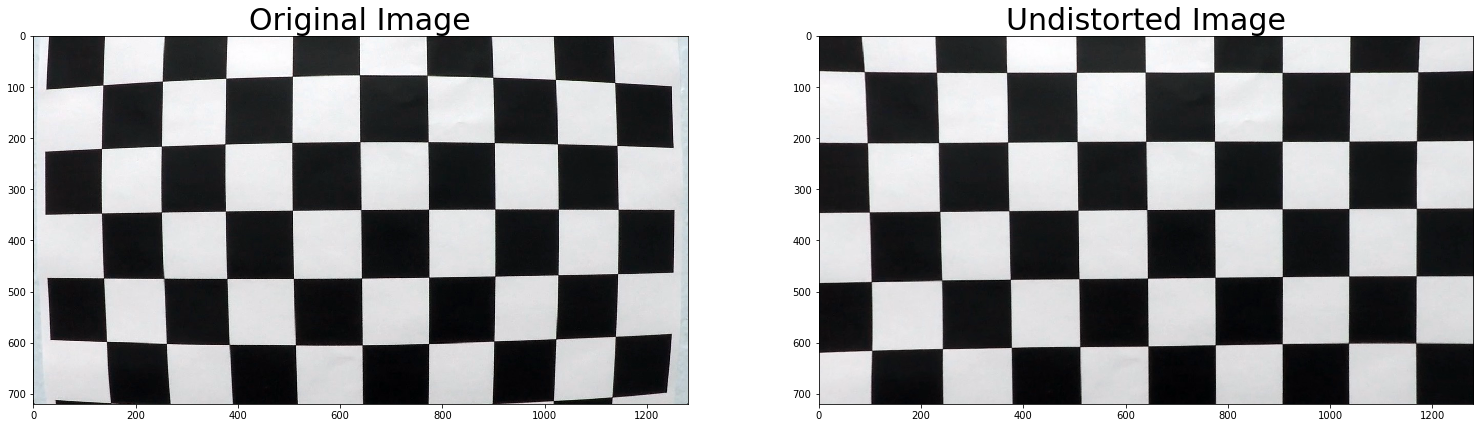

In [229]:
# Test undistortion on an image
image = cv2.imread('camera_cal/calibration1.jpg')
img_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration1_rev.jpg', dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration_wide_dist_pickle.p", "wb"))
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
name = 'undistorted'
plt.imsave('output_images/'+name+'.jpg', dst)

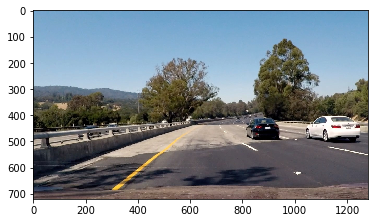

In [233]:
# Image imported
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print()

Perspective Transformation
===

In [234]:
def corner_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    h, w = gray.shape[:2]
      
    # Define source and destination
    src = np.float32([(570, 480),
                      (760, 480),
                      (320, 680),
                      (1100, 680)])         
    dst = np.float32([(320, 0), (1100, 0), 
                      (300, h), (1050, h)])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
        
    return undist, warped, M, Minv, src, dst

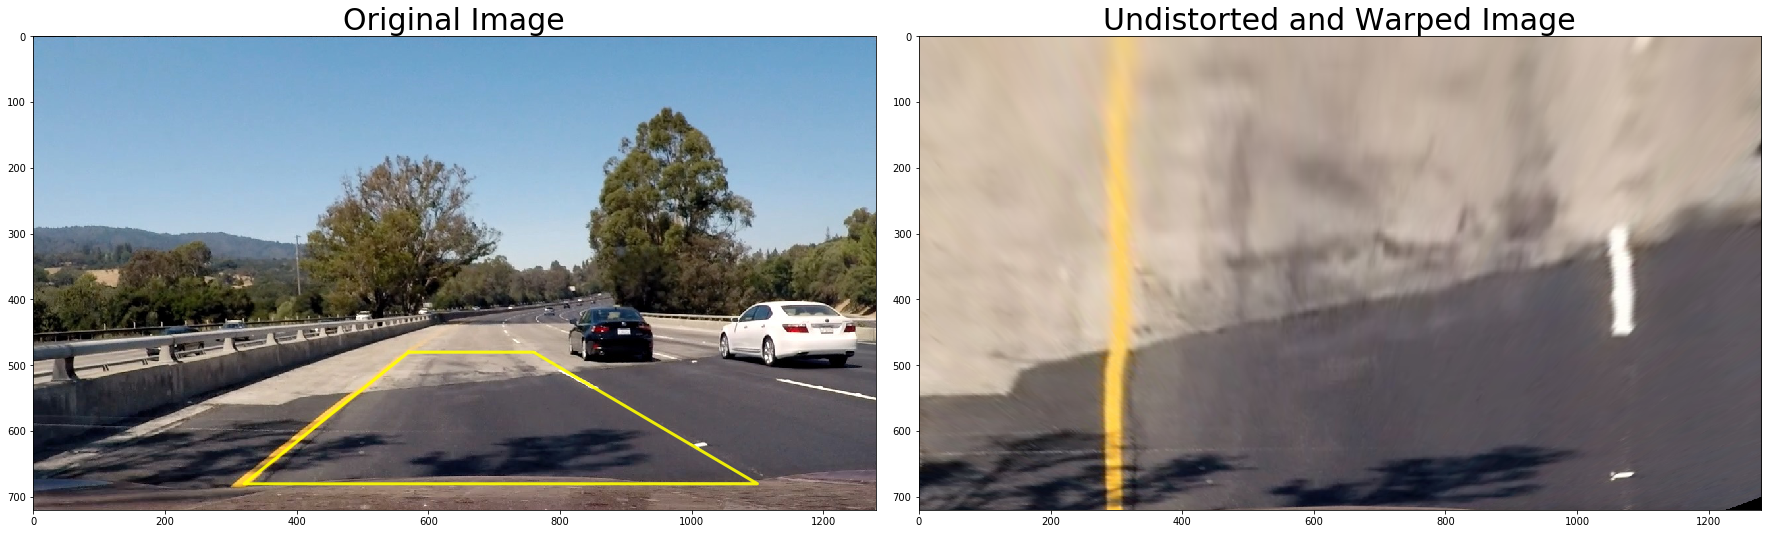

In [235]:
undist, top_down, perspective_M, Minv, src, dst = corner_unwarp(image, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
ax1.plot(x, y, color='#FFFF00', alpha=0.9, linewidth=3)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
name = 'bird_eye'
plt.imsave('output_images/'+name+'.jpg', top_down)

Edge Detection
===

#### Visualize Color Space Channels

In [7]:
def color_space_visualized(img):
    
    # Multiple color space channels
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    fig, axs = plt.subplots(4, 3, figsize=(20, 12))
    axs = axs.ravel()

    axs[0].axis('off')
    axs[0].imshow(img[:, :, 0])
    axs[0].set_title('RGB R-channel', fontsize=20)
    axs[1].axis('off')
    axs[1].imshow(img[:, :, 1])
    axs[1].set_title('RGB G-channel', fontsize=20)
    axs[2].axis('off')
    axs[2].imshow(img[:, :, 2])
    axs[2].set_title('RGB B-channel', fontsize=20)
    axs[3].axis('off')
    axs[3].imshow(img_HSV[:, :, 0])
    axs[3].set_title('HSV H-Channel', fontsize=20)
    axs[4].axis('off')
    axs[4].imshow(img_HSV[:, :, 1])
    axs[4].set_title('HSV S-channel', fontsize=20)
    axs[5].axis('off')
    axs[5].imshow(img_HSV[:, :, 2])
    axs[5].set_title('HSV V-Channel', fontsize=20)
    axs[6].axis('off')
    axs[6].imshow(img_HLS[:, :, 0])
    axs[6].set_title('HLS H-Channel', fontsize=20)
    axs[7].axis('off')
    axs[7].imshow(img_HLS[:, :, 1])
    axs[7].set_title('HLS L-channel', fontsize=20)
    axs[8].axis('off')
    axs[8].imshow(img_HLS[:, :, 2])
    axs[8].set_title('HLS S-Channel', fontsize=20)
    axs[9].axis('off')
    axs[9].imshow(img_LAB[:, :, 0])
    axs[9].set_title('LAB L-channel', fontsize=20)
    axs[10].axis('off')
    axs[10].imshow(img_LAB[:, :, 1])
    axs[10].set_title('LAB A-Channel', fontsize=20)
    axs[11].axis('off')
    axs[11].imshow(img_LAB[:, :, 2])
    axs[11].set_title('LAB B-Channel', fontsize=20)

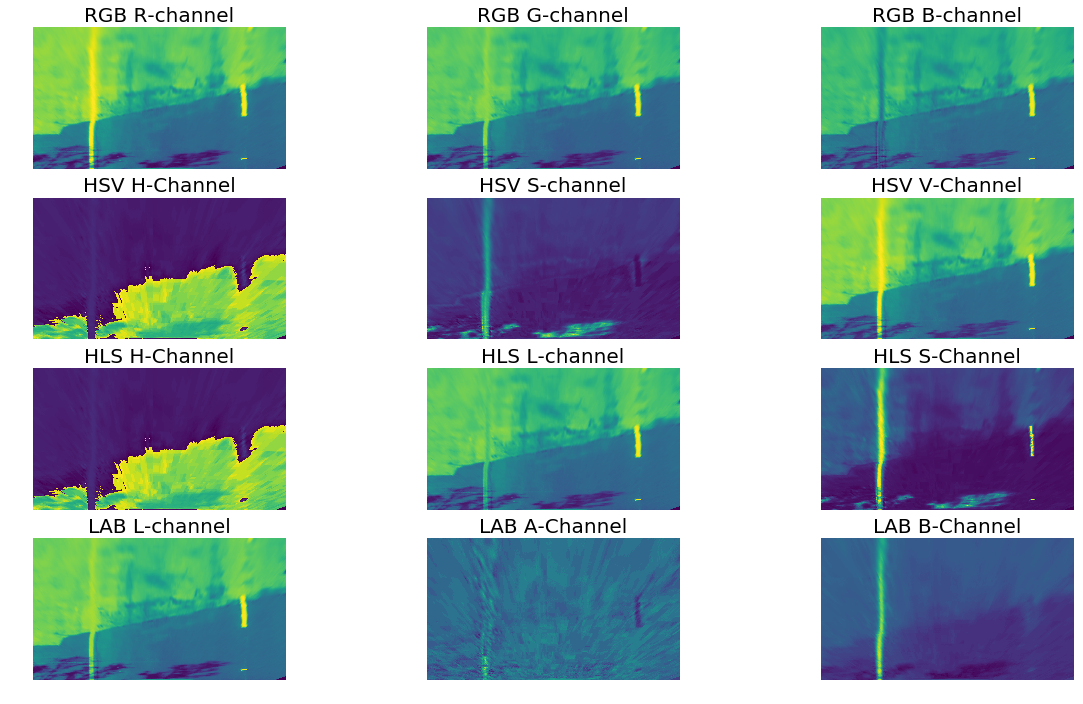

In [15]:
color_space_visualized(top_down)

#### Sobel Magnitude/Direction Threshold

In [8]:
def mag_dir_thresh(img, sobel_kernel=17, mag_thresh=(20, 134), dir_thresh=(0, 0.37)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute x and gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Calculate the direction of gradients
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag/255)
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_mag = np.zeros_like(gradmag)
    binary_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    binary_dir = np.zeros_like(graddir)
    binary_dir[(graddir >= dir_thresh[0]) & (graddir <= dir_thresh[1])] = 1  
    
    binary_output = np.zeros_like(binary_mag)
    binary_output[((binary_mag == 1) & (binary_dir == 1))] = 1
    
    return binary_output

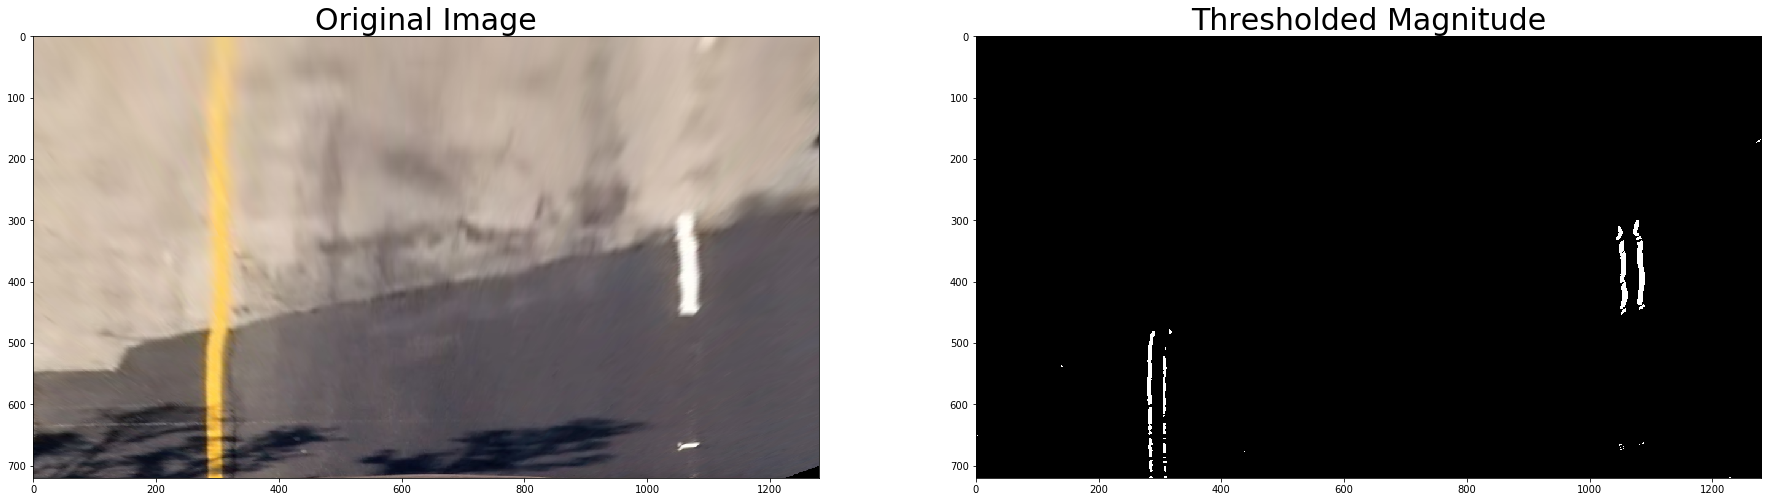

In [14]:
image = top_down

# Adjsut the sobel thresholds
def update_sobel(kernel, mag_min, mag_max, dir_min, dir_max):

    # Run the function
    mag_dir_binary = mag_dir_thresh(image, sobel_kernel=kernel, mag_thresh=(mag_min, mag_max), dir_thresh=(dir_min, dir_max))

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(mag_dir_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Interactive plot
interact(update_sobel, kernel=(1, 20, 2), 
                       mag_min=(0, 100), 
                       mag_max=(0, 255),
                       dir_min=(0, np.pi/2, 0.01), 
                       dir_max=(0, np.pi/2, 0.01))
print('')

#### Color Thresholding

In [10]:
def gray_thresh(img, thresh=(180, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

def RGB_thresh(img, thresh=(180, 255), channel=0):
    color_layer = img[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

def HSV_thresh(img, thresh=(15, 100), channel=0):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    color_layer = hsv[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

def HLS_thresh(img, thresh=(15, 100), channel=0):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_layer = hls[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

def LAB_thresh(img, thresh=(15, 100), channel=0):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    color_layer = lab[:, :, channel]
    binary = np.zeros_like(color_layer)
    binary[(color_layer > thresh[0]) & (color_layer <= thresh[1])] = 1
    return binary

In [11]:
# Adjust the color thresholds
def update_color_thresh(function, min_thresh, max_thresh, channel):
    if function=='gray_thresh':
        color_binary = gray_thresh(image, (min_thresh, max_thresh)) 
    elif function=='RGB_thresh':
        color_binary = RGB_thresh(image, (min_thresh, max_thresh), channel)
    elif function=='HSV_thresh':
        color_binary = HSV_thresh(image, (min_thresh, max_thresh), channel)
    elif function=='HLS_thresh':
        color_binary = HLS_thresh(image, (min_thresh, max_thresh), channel)
    elif function=='LAB_thresh':
        color_binary = LAB_thresh(image, (min_thresh, max_thresh), channel)
        
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(color_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Interactive plot
interact(update_color_thresh, function='HSV_thresh',
                              min_thresh=(0, 255), 
                              max_thresh=(0, 255),
                              channel=(0, 2, 1))
print('')    

### Image Processing Pipeline Setup

In [21]:
def image_process(img):
      
    # Undistortion and Transformation
    undist, top_down, perspective_M, Minv, src, dst = corner_unwarp(img, mtx, dist)
    
    # Threshold x gradient
    mag_dir_binary = mag_dir_thresh(top_down, sobel_kernel=11, mag_thresh=(50, 255), dir_thresh=(0, 0.39))
    
    # Threshold color channel
    hsv_v_binary = HSV_thresh(top_down, thresh=(200, 255), channel=2)
    hsv_v_binary[(hsv_v_binary >= 230) & (hsv_v_binary <= 255)] = 1
    hls_l_binary = HLS_thresh(top_down, thresh=(200, 255), channel=1)
    hls_l_binary[(hls_l_binary >= 200) & (hls_l_binary <= 255)] = 1
    lab_b_binary = LAB_thresh(top_down, thresh=(150, 255), channel=2)
    lab_b_binary[(lab_b_binary >= 200) & (lab_b_binary <= 255)] = 1
    
    #color_merge= np.dstack((np.zeros_like(hls_l_binary), hsv_v_binary, hls_l_binary, lab_b_binary))*255
    binary = np.zeros_like(hls_l_binary)   
    binary[(hls_l_binary == 1) | (lab_b_binary == 1) | (mag_dir_binary == 1) | (hsv_v_binary == 1)] = 1
    
    return binary, undist, Minv

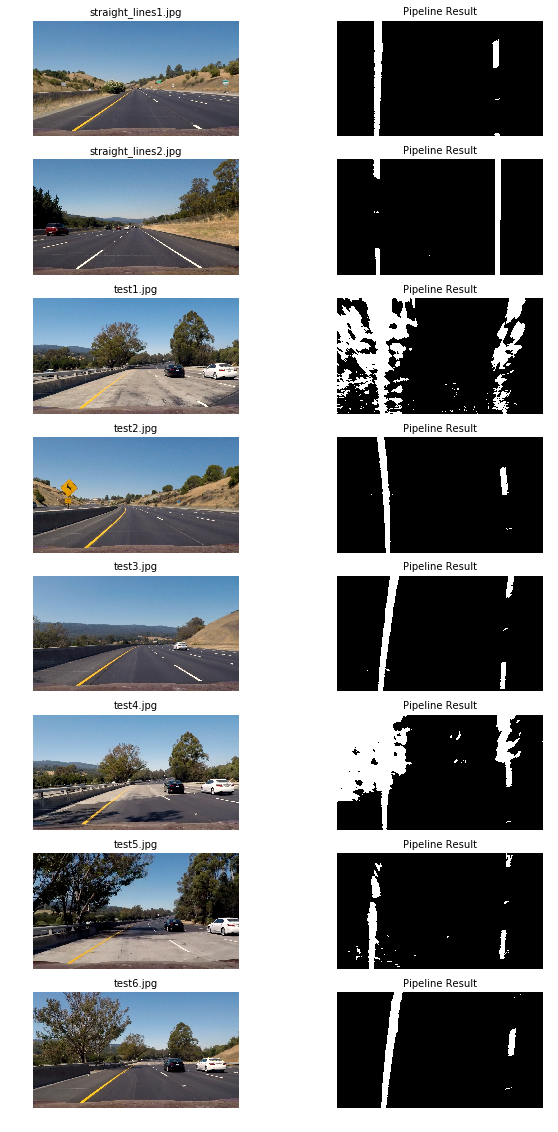

In [22]:
# Images imported from file named 'test_images'
images = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(len(images), 2, figsize=(10, 20))
axs = axs.ravel()

# Image processing
i = 0
for image in images:
    tag = image.split('/')[-1]
    test_img = cv2.imread(image)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    test_binary, undist, Minv = image_process(test_img)
    
    axs[i].imshow(test_img)
    axs[i].set_title(tag, fontsize=10)
    axs[i].axis('off')
    axs[i+1].imshow(test_binary, cmap='gray')
    axs[i+1].set_title('Pipeline Result', fontsize=10)
    axs[i+1].axis('off')
    
    i += 2

### Polynomial Curve Fitting
#### Find the Peaks in the Histogram

In [209]:
def poly_fit(binary_warped, undist, Minv, nwindows=12, margin=50, minpix=30):
    '''
    margin:  the width of the windows +/- margin
    minpix:  minimum number of pixels found to recenter window
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    rect_img = np.zeros_like(out_img)

    rect_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    rect_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    polyline = cv2.addWeighted(rect_img, 1, window_img, 0.3, 0)

    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    out_image = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad + right_curverad)/2
    curvature_radius = 'Radius of curvature: %.2f m' % curverad
    
    # Calculate the distance from the center of the lane
    center_distance = (640. - ((right_fitx[0]+left_fitx[0])/2)) * xm_per_pix
    if center_distance > 0:
        center_distance_str = 'Vehicle is %.2f m right of center' % abs(center_distance)
    else: 
        center_distance_str = 'Vehicle is %.2f m left of center' % abs(center_distance)
    
    # Add radius of curvation to the plot
    cv2.putText(out_image, curvature_radius, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

    # Add radius of curvation to the plot
    cv2.putText(out_image, center_distance_str, (100, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

    return out_image, histogram, out_img, polyline, left_fitx, right_fitx, ploty

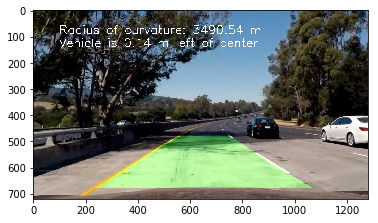

In [210]:
input = 'test_images/test5.jpg'
img = cv2.imread(input)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary, undist, Minv = image_process(img)
result, histogram, out_img, polyline, left_fitx, right_fitx, ploty = poly_fit(binary, undist, Minv, nwindows=12, margin=50, minpix=30)
plt.imshow(result)
print('')

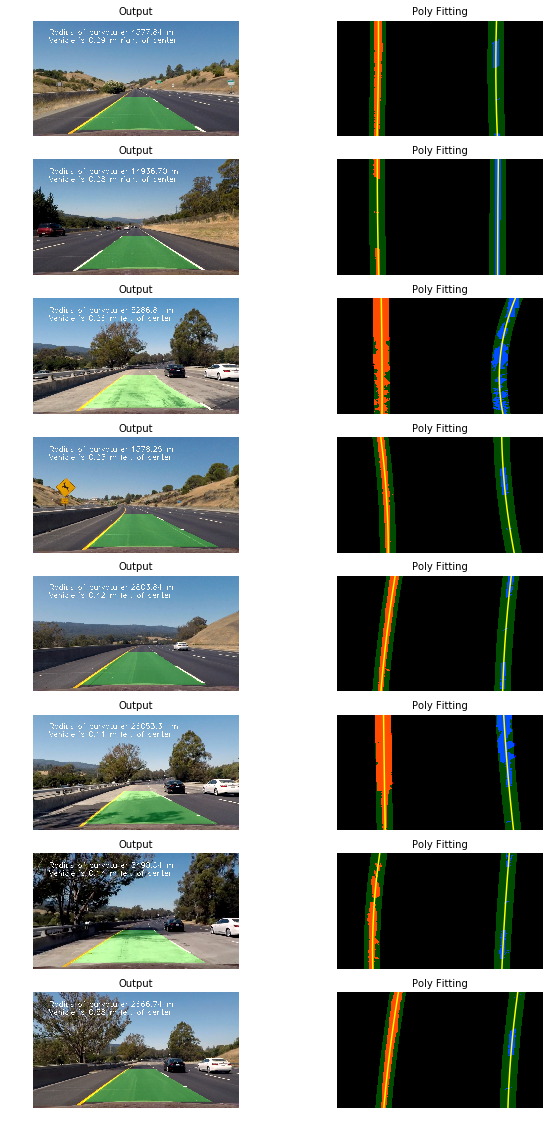

In [211]:
# Image imported
inputs = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(len(inputs), 2, figsize=(10, 20))
axs = axs.ravel()

# Image processing
i = 0
for input in inputs:
    tag = input.split('/')[-1]
    img = cv2.imread(input)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    binary, undist, Minv = image_process(img)
    result, histogram, out_img, polyline, left_fitx, right_fitx, ploty = poly_fit(binary, undist, Minv, nwindows=12, margin=50, minpix=30)
    
    axs[i].imshow(result)
    axs[i].set_title(tag, fontsize=10)
    axs[i].set_title('Output', fontsize=10)
    axs[i].axis('off')
    axs[i+1].imshow(polyline)
    axs[i+1].set_title('Poly Fit', fontsize=10)
    axs[i+1].plot(left_fitx, ploty, color='yellow')
    axs[i+1].plot(right_fitx, ploty, color='yellow') 
    axs[i+1].set_title('Poly Fitting', fontsize=10)
    axs[i+1].axis('off')
    
    i += 2

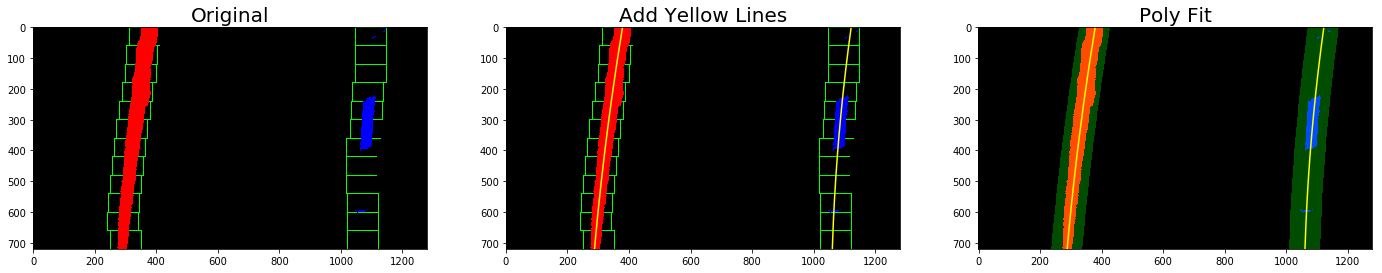

In [212]:
# Plot the windows
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(out_img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Add Yellow Lines', fontsize=20)
ax3.imshow(polyline)
ax3.set_title('Poly Fit', fontsize=20)
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')
print('')

### Project Pipeline Setup

#### Define Line Class

In [213]:
def lane_line_detect(image):
    
    img = np.copy(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary, undist, Minv = image_process(img)
    result, histogram, out_img, polyline, left_fitx, right_fitx, ploty = poly_fit(binary, undist, Minv, nwindows=12, margin=50, minpix=30)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    
    return result

### Project Video Processing
#### Baseline

In [214]:
video_output = 'project_video_output_2.mp4'
video_clip = VideoFileClip('project_video.mp4')
processed_video = video_clip.fl_image(lane_line_detect)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [03:59<00:00,  5.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 18s, sys: 52.1 s, total: 5min 10s
Wall time: 4min


#### Challenging

In [223]:
# Image clip from the video
def extract_frames(video, times, img_dir):
    clip = VideoFileClip(video)
    for i, t in enumerate(times):
        path = img_dir+str(i)+'.jpg'
        clip.save_frame(path, t)

In [ ]:
# Extract a few images from the challenging video
video = 'challenge_video.mp4'
img_dir = 'challenge_images/test'
times = (3.0, 5.0, 7.0, 9.0, 11.0)
extract_frames(video, times, img_dir)

In [186]:
challenge_output = 'challenge_video_output.mp4'
challenge_clip = VideoFileClip('challenge_video.mp4')
processed_challenge = challenge_clip.fl_image(lane_line_detect)
%time processed_challenge.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:29<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 37s, sys: 20.6 s, total: 1min 57s
Wall time: 1min 30s


### Reference
https://www.intmath.com/applications-differentiation/8-radius-curvature.php